In [202]:
import numpy as np

In [209]:
for j, k in list(zip(*np.where(data.mask == False))):
    print(j,k)

78 0
78 1
78 2714
79 0
79 1
79 2
79 2714
80 0
80 1
80 2
80 3
80 4
80 5
80 6
80 7
80 8
80 9
80 10
80 2714
81 0
81 1
81 2
81 3
81 4
81 5
81 6
81 7
81 8
81 9
81 10
81 2714
82 0
82 1
82 2
82 3
82 4
82 5
82 6
82 7
82 8
82 9
82 10
82 11
82 2714
83 0
83 1
83 2
83 3
83 4
83 5
83 6
83 7
83 8
83 9
83 10
83 11
83 12
83 13
83 14
83 15
83 2714
84 0
84 1
84 2
84 3
84 4
84 5
84 6
84 7
84 8
84 9
84 10
84 11
84 12
84 13
84 14
84 15
84 16
84 17
84 18
84 19
84 20
84 23
84 24
84 25
84 26
84 27
84 28
84 2714
85 0
85 1
85 2
85 3
85 4
85 5
85 6
85 7
85 8
85 9
85 10
85 11
85 12
85 13
85 14
85 15
85 16
85 17
85 18
85 19
85 20
85 21
85 22
85 23
85 24
85 25
85 26
85 27
85 28
85 29
85 30
85 31
85 32
85 33
85 34
85 35
85 2714
86 0
86 1
86 2
86 3
86 4
86 5
86 6
86 7
86 8
86 9
86 10
86 11
86 12
86 13
86 14
86 15
86 16
86 17
86 18
86 19
86 20
86 21
86 22
86 23
86 24
86 25
86 26
86 27
86 28
86 29
86 30
86 31
86 32
86 33
86 34
86 35
86 36
86 37
86 38
86 2714
87 0
87 1
87 2
87 3
87 4
87 5
87 6
87 7
87 8
87 9
87 10
87 11

In [210]:
stuff = list(zip(*np.where(data.mask == False)))
cols = np.unique([col for row, col in stuff])
cols
rows = [row for row, col in stuff if col == np.random.choice(cols)]

In [214]:
def get_random_location():
    with np.load('/home/catherinej/BarrierBreach/data/masked_island.npz') as npz:
        island = np.ma.MaskedArray(**npz)
    island_indices = list(zip(*np.where(island.mask == False)))
    lons = np.unique([lon for lat, lon in island_indices])
    random_lon = np.random.choice(lons)
    lats = [lat for lat, lon in island_indices if lon == random_lon]
    return lats[0], lats[-1], random_lon

In [215]:
print(get_random_location())

(313, 335, 740)


In [219]:
# Import topogrpahy to check random location is on the island
from clawpack.geoclaw import topotools
region=[-72.88560186665958, -72.63430557035839,
        40.71837964443896, 40.828287051848505]
topo = topotools.read_netcdf('/home/catherinej/bathymetry/moriches.nc')
topo_data = topo.crop(region)
topo_data.Z[313:335,740]

array([0.15021859, 1.1644047 , 1.9718782 , 1.9183604 , 2.2794757 ,
       2.8387094 , 3.5033276 , 3.3357449 , 2.8668094 , 3.5105817 ,
       2.8098974 , 2.07087   , 1.6177791 , 1.3945055 , 1.4612547 ,
       1.4613823 , 1.5331472 , 1.2271104 , 0.69336116, 0.4511666 ,
       0.44298452, 0.2665438 ], dtype=float32)

In [147]:
def calc_random_distance(lat, lon):
    total_width = np.random.randint(25,300)
    m_per_deg = np.pi/180 * 6371000 * np.cos(lat * np.pi/180)
    dist = total_width / m_per_deg
    east = lon - dist/2
    west = lon + dist/2  
    return east, west

print(calc_random_distance(40.81, -72.25))

(-72.25104561088528, -72.24895438911472)


In [150]:
def random_num_breaches():
    num_breaches = np.random.randint(0,10)
    return num_breaches
print(random_num_breaches())

4


In [169]:
def get_storm_start(ds):
    eye = ds.eye_loc.data
    lat_row = np.where(eye[:,1] > 22.0)
    lon_row = np.where(eye[:,0] < -58.0)
    idx = max(min(lat_row[0]), min(lon_row[0]))
    return int(ds.time.isel(time=idx).values)


def get_landfall(storm_no, ds):
    import pandas as pd
    storm_param_df = pd.read_csv('/home/catherinej/NACCS_data/NACCS_TS_Sim0_Post0_ST_TROP_Param.csv')
    storm_param_df = storm_param_df.iloc[2:]
    storm_param_df['Storm ID'] = storm_param_df['Storm ID'].astype('int')
    # Subset the storm_param_df to get only the 11 storms
    storm_df = storm_param_df[storm_param_df['Storm ID'] == storm_no]
    storm_df = storm_df.drop(['Unnamed: 9'], axis=1)
    print(storm_df)
    # Get eye_loc
    eye = ds.eye_loc.data
    lat_row = np.where(eye[:,1] >= float(storm_df['Reference Latitude'].values))
    lon_row = np.where(eye[:,0] <= float(storm_df['Reference Longitude'].values))
    idx = max(min(lat_row[0]), min(lon_row[0]))
    landfall_time = ds.time[idx].values
    
    return landfall_time

def get_depth(breach_num):
    depth = np.random.uniform(0,-2.0)
    return depth


def random_breach_time(storm_no):
    import xarray as xr
    import pandas as pd
    import numpy as np
    
    ds = xr.open_dataset(f'/home/catherinej/storm_files/NACCS_TP_{storm_no:04}_SYN_L2.nc')
    storm_start = get_storm_start(ds)
    landfall_time = get_landfall(storm_no, ds)
    random_start = np.random.randint(storm_start, landfall_time)
    random_stop = np.random.randint(random_start, landfall_time + 7200)
    return random_start, random_stop

In [163]:
print(random_breach_time(486))

         Storm Name  Storm ID          Storm Type Central Pressure Deficit  \
487  Synthetic_0486       486  Tropical_Synthetic                       48   

    Heading Direction Radius of Maximum Wind Reference Latitude  \
487                 0                     49              40.68   

    Reference Longitude Translational Speed  
487              -73.31                  58  
(156299, 183177)


In [183]:
import pandas as pd
gauges = pd.read_csv('/home/catherinej/BarrierBreach/src/visualization/ocean_gauges.csv')

In [184]:
gauges = gauges.drop(['Unnamed: 0','dist'], axis=1)

In [185]:
gauges

,lon,lat
0,-72.583333,40.806531
1,-72.587500,40.806177
2,-72.591667,40.806547
3,-72.595000,40.805151
4,-72.597500,40.803837
...,...,...
87,-72.865833,40.728706
88,-72.869167,40.727642
89,-72.872500,40.727093
90,-72.876667,40.726799


In [220]:
breach_loc = [-72.728378, (40.770121 + 40.77683)/2]
breach_loc

[-72.728378, 40.7734755]

In [244]:
def find_nearest_bathy_val(topo_data, breach_lat, breach_lon):
    X, Y = np.meshgrid(topo_data.x, topo_data.y)
    abslat = np.abs(Y- breach_lat)
    abslon = np.abs(X - breach_lon)
    c = np.maximum(abslon, abslat)
    y, x = np.where(c==np.min(c))
    x_deg = topo_data.x[x]
    y_deg = topo_data.y[y]
    return x, y, x_deg, y_deg

In [222]:
with np.load('/home/catherinej/BarrierBreach/data/masked_island.npz') as npz:
    island = np.ma.MaskedArray(**npz)

In [245]:
x, y, x_loc, y_loc = find_nearest_bathy_val(topo_data, breach_loc[1], breach_loc[0])

In [248]:
true_breach_loc = [y_loc, x_loc]

In [396]:
def get_bearing():
    import math
    # Upper adn lower points along moriches barrier island
    llon = -72.875
    ulon = -72.59
    llat = 40.73
    ulat = 40.81
    dLon = (ulon - llon)
    x = math.cos(math.radians(ulat)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(llat)) * math.sin(math.radians(ulat)) - math.sin(math.radians(llat)) * math.cos(math.radians(ulat)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)

    return brng

bay_coords = [-72.875, -72.59, 40.73, 40.81]
bearing = get_bearing()

In [397]:
bearing

69.5701076568244

In [274]:
def get_vector_points(lat, lon, bearing, distance):
    import math

    R = 6371 * 1000 #Radius of the Earth
    brng = math.radians(bearing) #Bearing is 90 degrees converted to radians.
    d = distance #Distance in m

    #lat2  52.20444 - the lat result I'm hoping for
    #lon2  0.36056 - the long result I'm hoping for.

    lat1 = math.radians(lat) #Current lat point converted to radians
    lon1 = math.radians(lon) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return lat2, lon2

In [275]:
true_breach_loc

[array([40.77347224]), array([-72.72837964])]

In [276]:
lat2, lon2 = get_vector_points(true_breach_loc[0], true_breach_loc[1], bearing, 1)

In [281]:
lat1, lon1 = get_vector_points(true_breach_loc[0], true_breach_loc[1], bearing, -1)

In [389]:
def calc_distance(lat1, lat2, lon1, lon2):
    from math import sin, cos, sqrt, atan2, radians
    R = 6371*1000
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1)*cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def gauges_locs_semicircle(gauge_x, gauge_y, center_x, 
                           center_y, radius, lon1, lat1):
    v1 = [lon1 - center_x, lat1 - center_y] # vect1 = b - center_pt
    v2 = [gauge_x - center_x, gauge_y - center_y] # p - center_pt
    xp = v1[0]*v2[1] - v1[1]*v2[0]
    dist_to_center = calc_distance(gauge_y, center_y, gauge_x, center_x)
    if xp < 0: # gauge is to right of line (ie ocean)
        if dist_to_center <= radius:
            return dist_to_center


In [398]:
gauges = pd.read_csv('/home/catherinej/BarrierBreach/src/visualization/ocean_gauges.csv', usecols=[1,2])
gauges

,lon,lat
0,-72.583333,40.806531
1,-72.587500,40.806177
2,-72.591667,40.806547
3,-72.595000,40.805151
4,-72.597500,40.803837
...,...,...
87,-72.865833,40.728706
88,-72.869167,40.727642
89,-72.872500,40.727093
90,-72.876667,40.726799


In [391]:
gauges = gauges.drop('Unnamed: 0', axis=1)
gauges = gauges.drop('dist', axis=1)

In [392]:
gauges['dist'] = [gauges_locs_semicircle(x, y, true_breach_loc[1],
                                         true_breach_loc[0], 1000,
                                         lon2, lat2) for x, y in zip(gauges['lon'],
                                                                     gauges['lat'])]

In [393]:
df = gauges[~gauges['dist'].isnull()]
df

,lon,lat,dist
40,-72.717500,40.774613,925.174966
41,-72.719808,40.772500,730.078851
42,-72.721667,40.770551,652.174123
43,-72.725000,40.769937,485.478434
44,-72.729167,40.769348,463.484940
45,-72.732413,40.768333,664.962959
46,-72.733797,40.765833,964.480195


In [370]:
df.dist.astype('float').idxmin()

44

In [400]:
df.index.values

array([40, 41, 42, 43, 44, 45, 46])

In [ ]:
def check_breach_location_viability():
    
    # get max dune height
    max_dune = max_dune_height(topo_data, ylow, yhigh, x)
    
    # Get bearing for island
    bearing = get_bearing()
    
    # get half circle lat/lon (point b) distance in m
    distance = 1000 # meters
    ulat, ulon = get_vector_points(llat, llon, bearing, distance)
    
    # get all gauges inside the half circle
    gauge_df = pd.read_csv('/home/catherinej/BarrierBreach/src/visualization/ocean_gauges.csv', usecols[1,2])
    gauge_df['dist'] = [gauges_locs_semicircle(x, y, true_breach_loc[1],
                                         true_breach_loc[0], 1000,
                                         lon2, lat2) for x, y in zip(gauges['lon'],
                                                                     gauges['lat'])]
    df = gauge_df[~gauge_df['dist'].isnull()]
    
    # load all gauge_data for that subset of gauges
    gauge_data_df = load_gauge_data(df.index.values)
    
    # get point where gauge_data exceeds x% dune height and index (for time stamp)
    x_percent = max_dune * .30
    
    # is the max gauge x% of dune height?
    cols_greater = (gauge_data_df >= x_percent).any()
    all_breach_times = first_greater(df, n, col):

    
    breach_indx = [first_greater(gauge_data_df, x_percent, col) for col in cols_greater.index]
    first_index = min([x for x in breach_indx if type(x) == np.float64])
    if isinstance(first_index, float):
        
        # yes proceed
        # get random width/depth
        # breach stop time is start + 2hours?
        
    else:
        with open(f'failed_location_{x}/{y}.data', 'rw') as f:
            f.write(f'Breach location failed: {} {}'# no write to file as failed location
    

In [372]:
def max_dune_height(topo_data, ylow, yhigh, x):
    return topo_data.Z[ylow:yhigh, x].max()


4.1706343

In [401]:
x_30 = 4.1706343 * .30

In [446]:
def load_gauge_data(gauge_names):
    import os
    gauge_data_list = []
    for gauge in gauge_names:
        if gauge > 40:
            cols = ['Time', f'{gauge}_eta']
            gauge_path = os.path.join('/home/catherinej/486/sensitivity_refinement/18m/_output', f'gauge5{gauge:04}.txt')
            df = pd.read_csv(gauge_path, skiprows=3, header=None, delim_whitespace=True,
                             usecols=[1,5], index_col='Time', names=cols)
            gauge_data_list.append(df)
    gauge_data_df = pd.concat(gauge_data_list, axis=1)
    return gauge_data_df

In [447]:
gauge_data_df = load_gauge_data(df.index.values)

In [ ]:


m1 = (gauge_data_df >= 4.17*.30).any()


def first_greater(df, n, col):
    m = df[col].gt(n)
    return m.any() and m.idxmax()

all_first = [first_greater(gauge_data_df, 4.17*.325, col) for col in m1.index]
min([x for x in all_first if type(x) == np.float64])

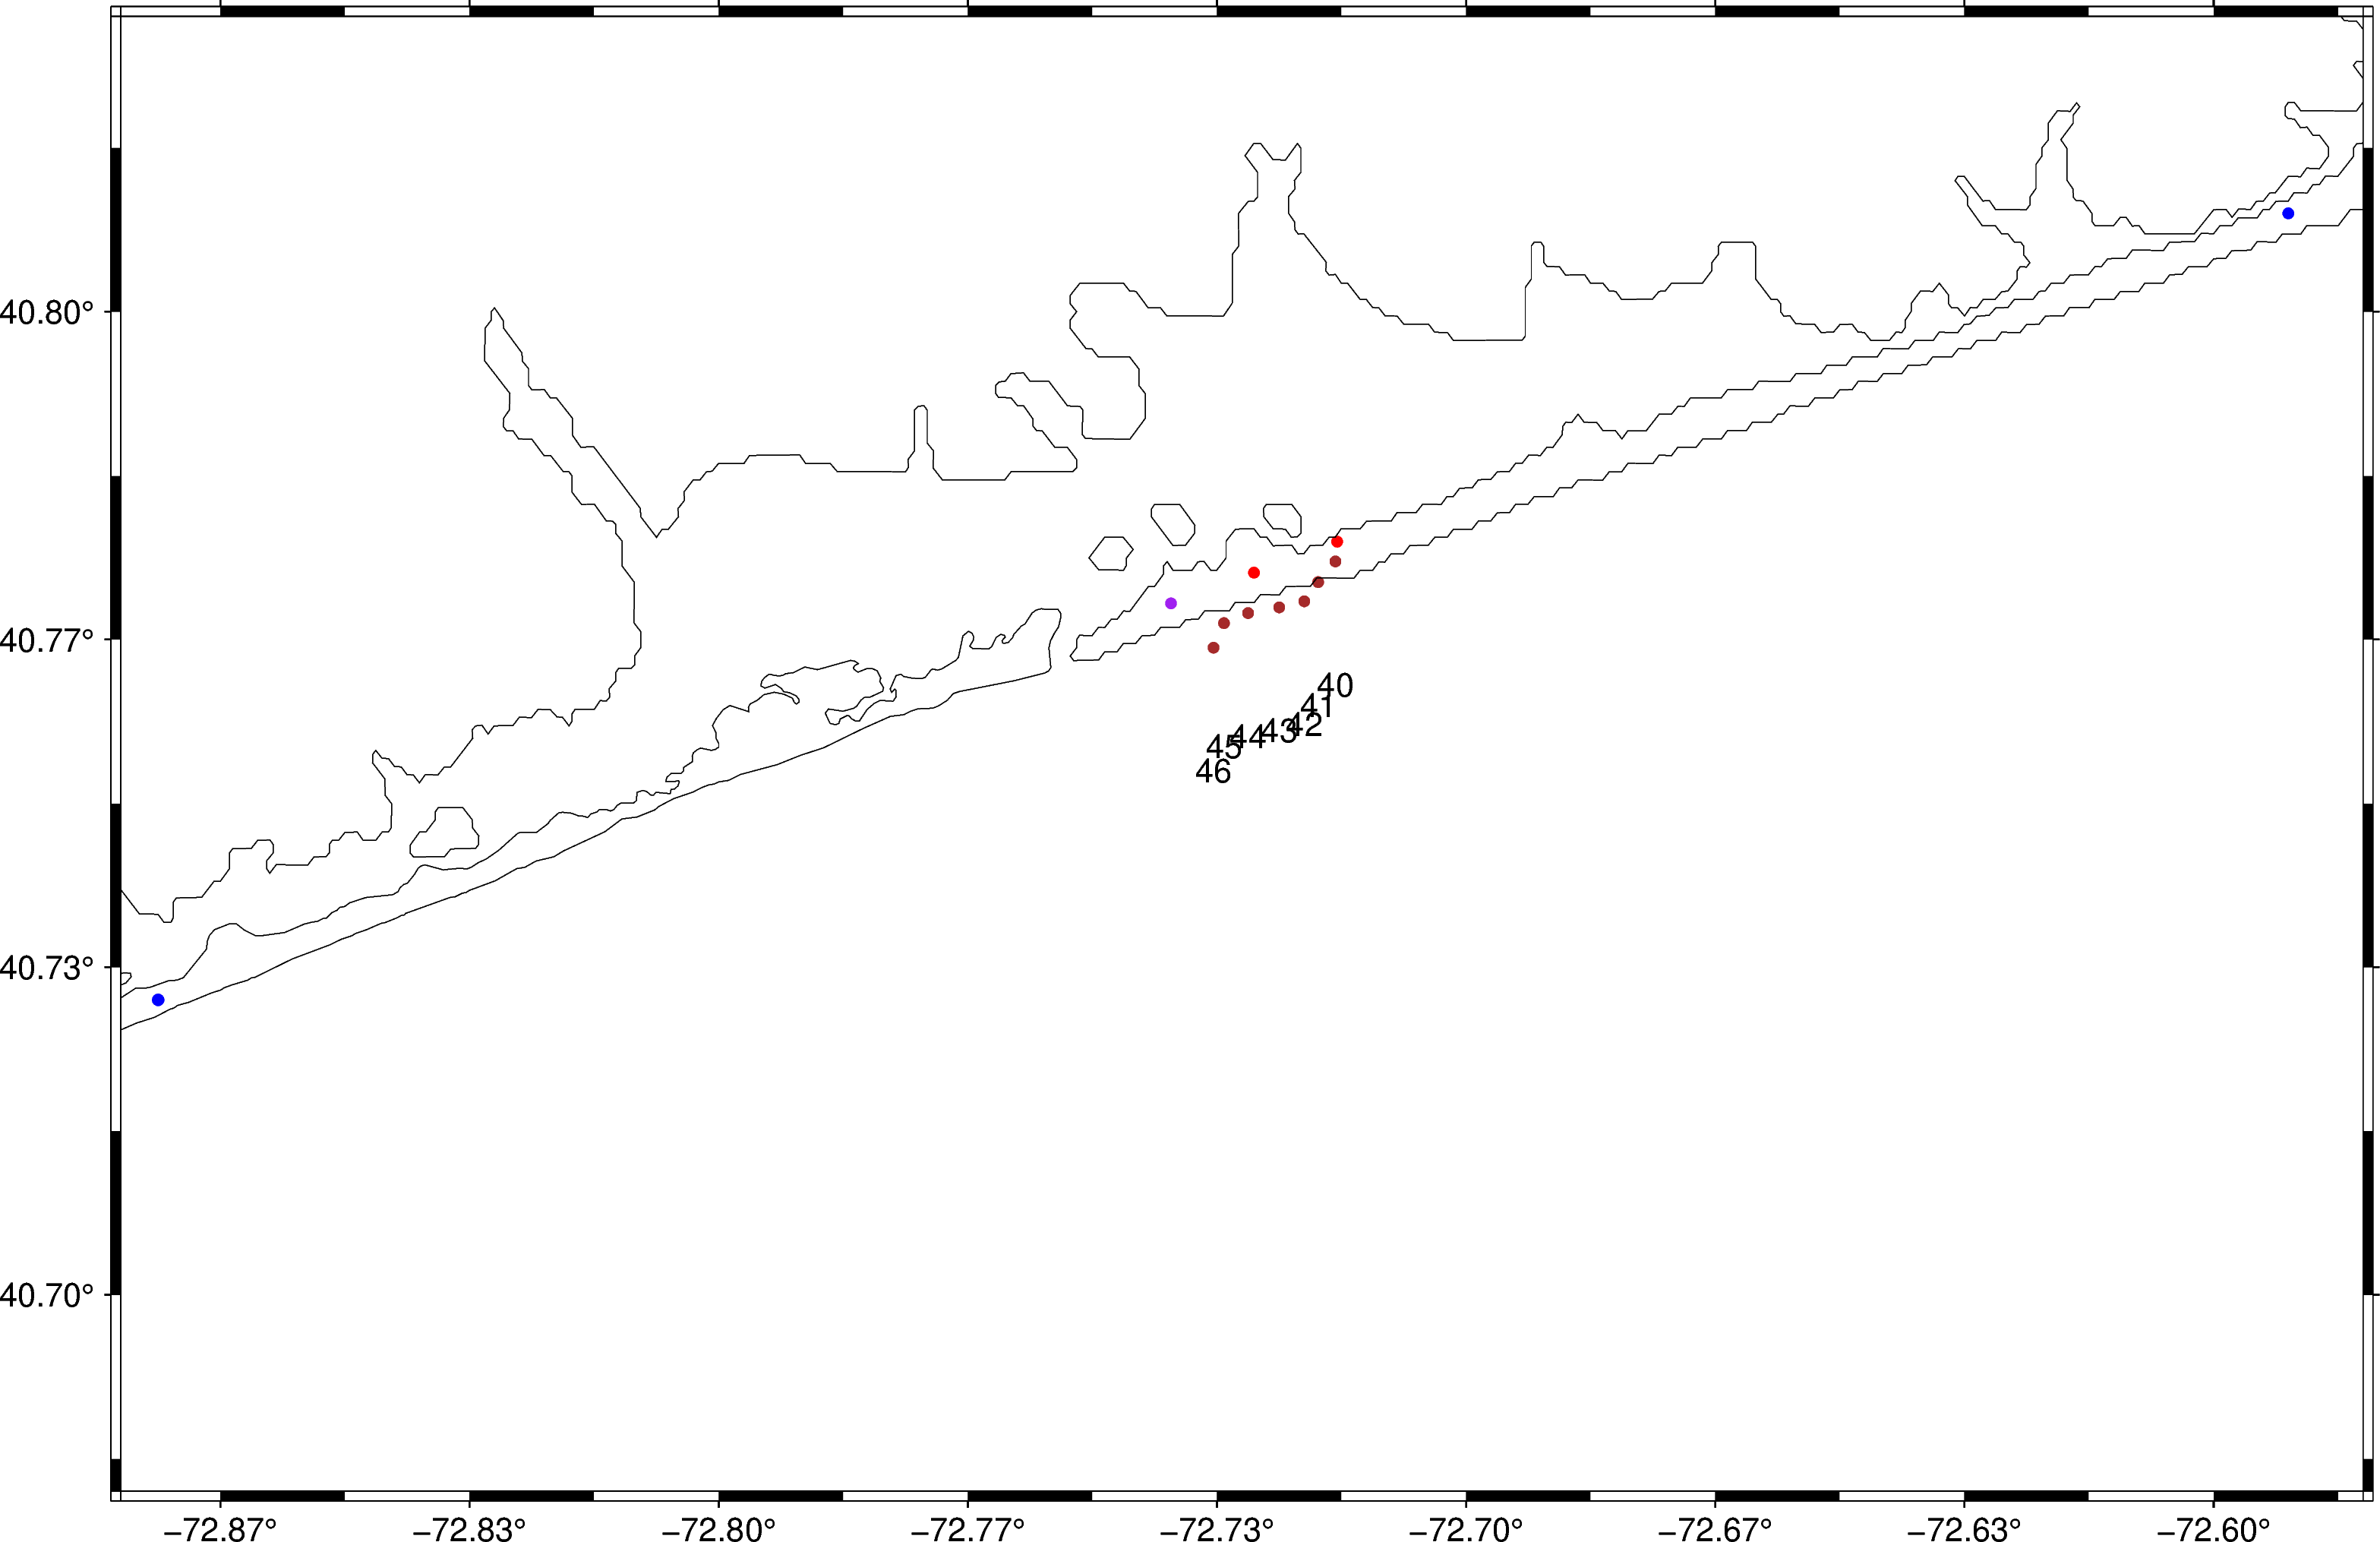

In [428]:
import pygmt
fig = pygmt.Figure()
grd = pygmt.datasets.load_earth_relief(region= [-72.88, -72.58, 40.68, 40.83],resolution='01s',)
with pygmt.config(
    FORMAT_GEO_MAP='ddd.xx'):
    fig.basemap(region=[-72.88, -72.58, 40.68, 40.83], projection='M25c', frame=True)
    fig.plot(x=df['lon'], y=df['lat'], color='brown', style='c0.125c')
    fig.plot(x=true_breach_loc[1], y=true_breach_loc[0], color='red', style='c0.125c')
    fig.plot(x=lon2, y=lat2, color='red', style='c0.125c')
    fig.plot(x=lon1, y=lat1, color='purple', style='c0.125c')
    fig.plot(x=bay_coords[0], y=bay_coords[2], color='blue', style='c0.135c')
    fig.plot(x=bay_coords[1], y=bay_coords[3], color='blue', style='c0.125c')
    fig.text(x=df['lon'], y=df['lat']-0.0125, text=df.index)
    fig.coast(shorelines=True)
    fig.show()

In [577]:
x = 12.1

In [579]:
isinstance(x, float)

True